Thực hiện chiến lược DFF, sử dụng mô hình DFF.h5

Thực hiện get data thị trường chứng khoán việt nam

In [31]:
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
from sklearn.preprocessing import StandardScaler
import numpy as np
import talib as ta
import pandas as pd
import yfinance as yf


# Tải dữ liệu giá cổ phiếu MSFT từ 1/1/2020 đến ngày hiện tại
data = yf.download('EURUSD=X', start='2024-05-15', interval='15m')

[*********************100%%**********************]  1 of 1 completed


In [32]:
data.dropna()

,Open,High,Low,Close,Adj Close,Volume
Datetime,,,,,,
2024-05-15 00:00:00,1.081900,1.081900,1.081783,1.081900,1.081900,0
2024-05-15 00:15:00,1.081900,1.081900,1.081783,1.081783,1.081783,0
2024-05-15 00:30:00,1.081900,1.081900,1.081666,1.081783,1.081783,0
2024-05-15 00:45:00,1.081783,1.081900,1.081666,1.081783,1.081783,0
2024-05-15 01:00:00,1.081666,1.081900,1.081666,1.081900,1.081900,0
...,...,...,...,...,...,...
2024-05-17 00:30:00,1.086957,1.086957,1.086957,1.086957,1.086957,0
2024-05-17 00:45:00,1.086957,1.087075,1.086957,1.087075,1.087075,0
2024-05-17 01:00:00,1.087075,1.087075,1.086720,1.086720,1.086720,0


Thực hiện tính các indicator cần thiết

In [33]:
# Tải mô hình đã được lưu trước
model = load_model('dff_forex.h5')

# Tính toán các chỉ số kỹ thuật (EMA, AU, AD)
data['EMA'] = data['Close'].ewm(span=21, adjust=False).mean()
delta = data['Close'].diff()
gain = delta.where(delta > 0, 0)
loss = -delta.where(delta < 0, 0)
data['AU'] = gain.rolling(window=14, min_periods=1).mean()
data['AD'] = loss.rolling(window=14, min_periods=1).mean()
#Tính toán thêm các indicator khác:
data['RSI'] = ta.RSI(data['Close'], timeperiod=14)
data['ERSI'] = ta.EMA(data['RSI'], timeperiod=14)

data

,Open,High,Low,Close,Adj Close,Volume,EMA,AU,AD,RSI,ERSI
Datetime,,,,,,,,,,,
2024-05-15 00:00:00,1.081900,1.081900,1.081783,1.081900,1.081900,0,1.081900,0.000000,-0.000000,NaN,NaN
2024-05-15 00:15:00,1.081900,1.081900,1.081783,1.081783,1.081783,0,1.081889,0.000000,0.000058,NaN,NaN
2024-05-15 00:30:00,1.081900,1.081900,1.081666,1.081783,1.081783,0,1.081879,0.000000,0.000039,NaN,NaN
2024-05-15 00:45:00,1.081783,1.081900,1.081666,1.081783,1.081783,0,1.081871,0.000000,0.000029,NaN,NaN
2024-05-15 01:00:00,1.081666,1.081900,1.081666,1.081900,1.081900,0,1.081873,0.000023,0.000023,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
2024-05-17 00:30:00,1.086957,1.086957,1.086957,1.086957,1.086957,0,1.087080,0.000034,0.000059,45.479094,46.794288
2024-05-17 00:45:00,1.086957,1.087075,1.086957,1.087075,1.087075,0,1.087080,0.000042,0.000051,49.058449,47.096176
2024-05-17 01:00:00,1.087075,1.087075,1.086720,1.086720,1.086720,0,1.087047,0.000042,0.000068,40.476196,46.213512


Thực hiện thêm mô hình

In [34]:
# Chuẩn hóa dữ liệu
scaler = StandardScaler()
features = ['EMA', 'AU', 'AD']
X = scaler.fit_transform(data[features])

# Dự đoán trạng thái thị trường
predicted_classes = np.argmax(model.predict(X), axis=1)

# Chuyển đổi trạng thái thị trường thành các label tương ứng
market_states = ['Downtrend', 'Uptrend', 'Sideway']
predicted_labels = [market_states[i] for i in predicted_classes]

data['Market_State'] = predicted_labels

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 


Kiểm  tra thử trạng thái thị trường

In [35]:
for i, (index, row) in enumerate(data.iterrows()):
    # In ra trạng thái thị trường và ngày tương ứng
    print(f"Date: {index}, Market State: {predicted_labels[i]}")

Date: 2024-05-15 00:00:00, Market State: Uptrend
Date: 2024-05-15 00:15:00, Market State: Downtrend
Date: 2024-05-15 00:30:00, Market State: Uptrend
Date: 2024-05-15 00:45:00, Market State: Uptrend
Date: 2024-05-15 01:00:00, Market State: Uptrend
Date: 2024-05-15 01:15:00, Market State: Uptrend
Date: 2024-05-15 01:30:00, Market State: Uptrend
Date: 2024-05-15 01:45:00, Market State: Uptrend
Date: 2024-05-15 02:00:00, Market State: Uptrend
Date: 2024-05-15 02:15:00, Market State: Uptrend
Date: 2024-05-15 02:30:00, Market State: Uptrend
Date: 2024-05-15 02:45:00, Market State: Uptrend
Date: 2024-05-15 03:00:00, Market State: Uptrend
Date: 2024-05-15 03:15:00, Market State: Uptrend
Date: 2024-05-15 03:30:00, Market State: Uptrend
Date: 2024-05-15 03:45:00, Market State: Uptrend
Date: 2024-05-15 04:00:00, Market State: Uptrend
Date: 2024-05-15 04:15:00, Market State: Uptrend
Date: 2024-05-15 04:30:00, Market State: Uptrend
Date: 2024-05-15 04:45:00, Market State: Uptrend
Date: 2024-05-15 0

Thực hiện kiểm tra điều kiện vào lệnh, tính toán các indicator thêm:

In [36]:


data.dropna()

,Open,High,Low,Close,Adj Close,Volume,EMA,AU,AD,RSI,ERSI,Market_State
Datetime,,,,,,,,,,,,
2024-05-15 06:45:00,1.082603,1.083072,1.082603,1.082954,1.082954,0,1.082560,0.000092,0.000059,63.987807,67.912475,Uptrend
2024-05-15 07:00:00,1.082954,1.083072,1.082837,1.082837,1.082837,0,1.082586,0.000067,0.000067,60.178706,66.881306,Uptrend
2024-05-15 07:15:00,1.082837,1.082837,1.082603,1.082720,1.082720,0,1.082598,0.000067,0.000075,56.556675,65.504688,Uptrend
2024-05-15 07:30:00,1.082720,1.082837,1.082720,1.082720,1.082720,0,1.082609,0.000059,0.000075,56.556675,64.311620,Uptrend
2024-05-15 07:45:00,1.082720,1.083306,1.082720,1.083306,1.083306,0,1.082672,0.000100,0.000075,67.804824,64.777381,Uptrend
...,...,...,...,...,...,...,...,...,...,...,...,...
2024-05-17 00:30:00,1.086957,1.086957,1.086957,1.086957,1.086957,0,1.087080,0.000034,0.000059,45.479094,46.794288,Uptrend
2024-05-17 00:45:00,1.086957,1.087075,1.086957,1.087075,1.087075,0,1.087080,0.000042,0.000051,49.058449,47.096176,Uptrend
2024-05-17 01:00:00,1.087075,1.087075,1.086720,1.086720,1.086720,0,1.087047,0.000042,0.000068,40.476196,46.213512,Downtrend


In [37]:
# Đặt lại tên chỉ mục
data.index.name = 'Date'

# Chuyển đổi chỉ mục từ text sang datetime
data.index = pd.to_datetime(data.index, format='%Y-%m-%d')

# Lấy năm và tháng hiện tại
current_year = pd.Timestamp.now().year
current_month = pd.Timestamp.now().month

# Lọc dữ liệu của tháng hiện tại
data_current_month = data[(data.index.year == current_year) & (data.index.month == current_month)]

# Loại bỏ các dòng có giá trị NaN
data_current_month = data_current_month.dropna()

# In toàn bộ dữ liệu của tháng hiện tại
print(data_current_month)

                         Open      High       Low     Close  Adj Close  \
Date                                                                     
2024-05-15 06:45:00  1.082603  1.083072  1.082603  1.082954   1.082954   
2024-05-15 07:00:00  1.082954  1.083072  1.082837  1.082837   1.082837   
2024-05-15 07:15:00  1.082837  1.082837  1.082603  1.082720   1.082720   
2024-05-15 07:30:00  1.082720  1.082837  1.082720  1.082720   1.082720   
2024-05-15 07:45:00  1.082720  1.083306  1.082720  1.083306   1.083306   
...                       ...       ...       ...       ...        ...   
2024-05-17 00:30:00  1.086957  1.086957  1.086957  1.086957   1.086957   
2024-05-17 00:45:00  1.086957  1.087075  1.086957  1.087075   1.087075   
2024-05-17 01:00:00  1.087075  1.087075  1.086720  1.086720   1.086720   
2024-05-17 01:15:00  1.086720  1.086720  1.086484  1.086484   1.086484   
2024-05-17 01:30:00  1.086484  1.086484  1.086366  1.086484   1.086484   

                     Volume       EMA

Thực hiện kiểm tra điều kiện hiện tại:

In [38]:
# print(data.last)

last_row = data.iloc[-1]
if(
    (last_row['RSI'] > last_row['ERSI'])
    and (last_row['Market_State'] == 'Uptrend')
    and (last_row['ERSI'] > 40 or last_row['ERSI'] < 60)
):
    print('buy')
else: print('Not buy this time')
last_row

def condition_buy(rsi, ersi, market_state):
    if ((rsi > ersi)
    and (market_state == 'Uptrend')
    and (ersi > 40 or ersi < 60)):
        return True
    else: return False

def condition_sell(rsi, ersi, market_state):
    if ((rsi< ersi)
    and (market_state == 'Downtrend')
    and (ersi > 40 or ersi < 60)):
        return True
    else: return False

Not buy this time


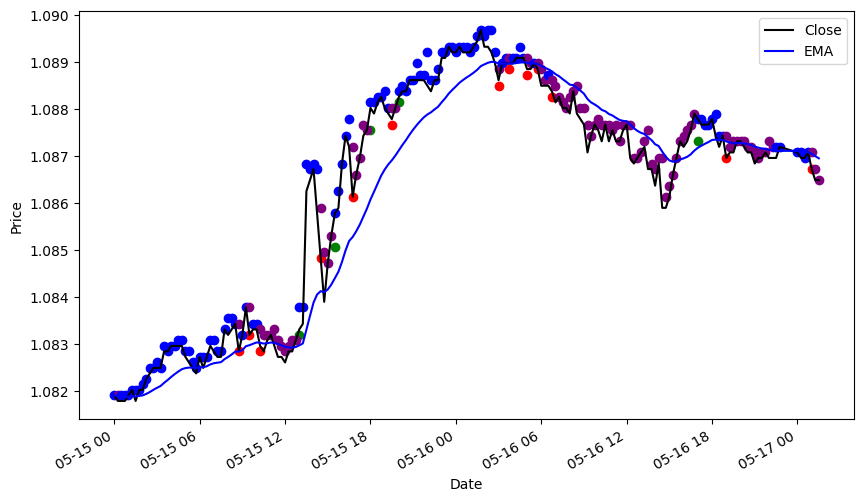

In [40]:
import pandas as pd
import mplfinance as mpf
import matplotlib.pyplot as plt

# Lọc dữ liệu từ năm
filtered_data = data.loc['2023-05-15':]
filtered_data

# Lấy giá trị của trạng thái thị trường
market_states = filtered_data[["RSI", "ERSI", "Market_State"]]
# Tạo một biến để lưu trữ trạng thái hiện tại của thị trường
current_market_state = None

# Vẽ biểu đồ nến
filtered_data['Close'].plot(figsize=(10, 6), color='black')
filtered_data['EMA'].plot(figsize=(10, 6), color='blue')

for index, row in market_states.iterrows():
    rsi = row['RSI']
    ersi = row['ERSI']
    market_state = row['Market_State']
    if market_state != current_market_state:
        current_market_state = market_state
        if(condition_buy(rsi , ersi, market_state) ):
            color = 'green'
            plt.scatter(index, filtered_data.loc[index, 'Low'], color=color, marker='o')
        if(condition_sell(rsi , ersi, market_state) ):
            color = 'red'
            plt.scatter(index, filtered_data.loc[index, 'Low'], color=color, marker='o')

for index, row in market_states.iterrows():
    market_state = row['Market_State']
    current_market_state = market_state
    if(market_state == "Uptrend"): color = 'blue' 
    else: color = 'purple'
    
    plt.scatter(index, filtered_data.loc[index, 'High'], color=color, marker='o')

# Đặt tiêu đề và nhãn trục
plt.xlabel('Date')
plt.ylabel('Price')

# Hiển thị chú thích
plt.legend()

# Hiển thị biểu đồ
plt.show()